In [1]:
from autometrics.dataset.datasets import HelpSteer
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.aggregator.regression import Ridge
from autometrics.generator.LLMJudgeProposer import LLMJudgeProposer
import dspy
import litellm
from prometheus_eval.litellm import LiteLLM
from autometrics.evaluate.accuracy import calculate_accuracy

import pandas as pd

pd.set_option('display.max_colwidth', None)

litellm.suppress_debug_info = True

/opt/miniconda3/envs/auto_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = HelpSteer()

In [3]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.1, seed=42, max_size=1000)

In [4]:
llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3.1-70b-Instruct", api_base="http://future-hgx-1:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [5]:
generator = LLMJudgeProposer(train_dataset=train, task_description="Answer the user query as a helpful chatbot assistant.", proposer_model=llama31_70b, judge_model=llama31_70b)

In [6]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3.1-70b-Instruct'

In [7]:
new_metrics = []

for target_column in dataset.target_columns:
    new_metrics.extend(generator.generate(train, target_column))

In [8]:
# Condense the metrics that have duplicate names
new_metrics_names = set()
new_metrics_final = []
for metric in new_metrics:
    if metric.name not in new_metrics_names:
        new_metrics_names.add(metric.name)
        new_metrics_final.append(metric)

In [9]:
train.add_metrics(new_metrics_final)
dev.add_metrics(new_metrics_final)
test.add_metrics(new_metrics_final)

Grading rows:  19%|█▉        | 344/1789 [00:00<00:00, 3244.58row/s]

Error processing row 608: Expected dict_keys(['reasoning', 'score']) but got dict_keys(['reasoning'])


Grading rows: 100%|██████████| 1789/1789 [00:03<00:00, 468.76row/s]


In [10]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
helpfulness,Accuracy_Meta-Llama-3.1-70b-Instruct (0.4611015783798727),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.4477223417573244),Coherence_Meta-Llama-3.1-70b-Instruct (0.4504531940982247),Informative value_Meta-Llama-3.1-70b-Instruct (0.4839150436345602),Relevance_Meta-Llama-3.1-70b-Instruct (0.4661231676503594)
correctness,Accuracy_Meta-Llama-3.1-70b-Instruct (0.4485083421344724),Coherence_Meta-Llama-3.1-70b-Instruct (0.44929705887857646),Relevance_Meta-Llama-3.1-70b-Instruct (0.46410884787576373),Informative value_Meta-Llama-3.1-70b-Instruct (0.4745493964935202),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.44004493100380415)
coherence,Accuracy_Meta-Llama-3.1-70b-Instruct (0.31563465682718983),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.3249545448469289),Coherence_Meta-Llama-3.1-70b-Instruct (0.3202154925772133),Relevance_Meta-Llama-3.1-70b-Instruct (0.34868954171048644),Conciseness_Meta-Llama-3.1-70b-Instruct (0.2505972282368095)
complexity,Engagement_Meta-Llama-3.1-70b-Instruct (0.28049555084988514),Completeness_Meta-Llama-3.1-70b-Instruct (0.2818820044696545),Informative value_Meta-Llama-3.1-70b-Instruct (0.16466861154932316),Tone_Meta-Llama-3.1-70b-Instruct (0.13838070971685512),Grammar and syntax_Meta-Llama-3.1-70b-Instruct (0.18420248668417935)
verbosity,Engagement_Meta-Llama-3.1-70b-Instruct (0.3456003023677312),Completeness_Meta-Llama-3.1-70b-Instruct (0.3087482950482836),Conciseness_Meta-Llama-3.1-70b-Instruct (-0.16186319481609845),Informative value_Meta-Llama-3.1-70b-Instruct (0.142585753545761),Grammar and syntax_Meta-Llama-3.1-70b-Instruct (0.1638828687211013)


In [11]:
display_top_5_metrics_by_validation(dev, test, True, calculate_accuracy)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
helpfulness,Engagement_Meta-Llama-3.1-70b-Instruct (0.4141978759083287),Completeness_Meta-Llama-3.1-70b-Instruct (0.2733370598099497),Conciseness_Meta-Llama-3.1-70b-Instruct (0.2146450531022918),Informative value_Meta-Llama-3.1-70b-Instruct (0.23588596981553941),Accuracy_Meta-Llama-3.1-70b-Instruct (0.1626607043040805)
correctness,Engagement_Meta-Llama-3.1-70b-Instruct (0.3890441587479039),Completeness_Meta-Llama-3.1-70b-Instruct (0.2984907769703745),Conciseness_Meta-Llama-3.1-70b-Instruct (0.23309111235326999),Informative value_Meta-Llama-3.1-70b-Instruct (0.24203465623253215),Accuracy_Meta-Llama-3.1-70b-Instruct (0.19508105086640581)
coherence,Completeness_Meta-Llama-3.1-70b-Instruct (0.35606484069312466),Accuracy_Meta-Llama-3.1-70b-Instruct (0.28283957518166575),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.26830631637786473),Conciseness_Meta-Llama-3.1-70b-Instruct (0.2688652878703186),Engagement_Meta-Llama-3.1-70b-Instruct (0.31302403577417554)
complexity,Engagement_Meta-Llama-3.1-70b-Instruct (0.1509223029625489),Conciseness_Meta-Llama-3.1-70b-Instruct (0.11011738401341531),Completeness_Meta-Llama-3.1-70b-Instruct (0.06987143655673561),Informative value_Meta-Llama-3.1-70b-Instruct (0.08608160983789827),Accuracy_Meta-Llama-3.1-70b-Instruct (0.05366126327557295)
verbosity,Engagement_Meta-Llama-3.1-70b-Instruct (0.18166573504751257),Conciseness_Meta-Llama-3.1-70b-Instruct (0.12968138624930128),Completeness_Meta-Llama-3.1-70b-Instruct (0.07210732252655115),Informative value_Meta-Llama-3.1-70b-Instruct (0.08272778088317496),Accuracy_Meta-Llama-3.1-70b-Instruct (0.06763555058692007)


In [12]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


In [13]:
train.get_metric_columns()

['Relevance_Meta-Llama-3.1-70b-Instruct',
 'Coherence_Meta-Llama-3.1-70b-Instruct',
 'Completeness_Meta-Llama-3.1-70b-Instruct',
 'Tone_Meta-Llama-3.1-70b-Instruct',
 'Contextual understanding_Meta-Llama-3.1-70b-Instruct',
 'Accuracy_Meta-Llama-3.1-70b-Instruct',
 'Engagement_Meta-Llama-3.1-70b-Instruct',
 'Informative value_Meta-Llama-3.1-70b-Instruct',
 'Grammar and syntax_Meta-Llama-3.1-70b-Instruct',
 'Conciseness_Meta-Llama-3.1-70b-Instruct']

In [14]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


In [15]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
helpfulness,Rg_helpfulness_llm (0.5164926118976537),Rg_correctness_llm (0.5173736256876135),Rg_coherence_llm (0.49271157089385487),Accuracy_Meta-Llama-3.1-70b-Instruct (0.4611015783798727),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.4477223417573244)
correctness,Rg_correctness_llm (0.5014371565474595),Rg_helpfulness_llm (0.5023946581136197),Accuracy_Meta-Llama-3.1-70b-Instruct (0.4485083421344724),Rg_coherence_llm (0.4821155759053533),Coherence_Meta-Llama-3.1-70b-Instruct (0.44929705887857646)
coherence,Accuracy_Meta-Llama-3.1-70b-Instruct (0.31563465682718983),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.3249545448469289),Coherence_Meta-Llama-3.1-70b-Instruct (0.3202154925772133),Relevance_Meta-Llama-3.1-70b-Instruct (0.34868954171048644),Rg_correctness_llm (0.35715665537246616)
complexity,Rg_complexity_llm (0.36642490506553177),Rg_verbosity_llm (0.3663044795869994),Engagement_Meta-Llama-3.1-70b-Instruct (0.28049555084988514),Completeness_Meta-Llama-3.1-70b-Instruct (0.2818820044696545),Rg_helpfulness_llm (0.2072596560320194)
verbosity,Rg_verbosity_llm (0.4558330465555793),Rg_complexity_llm (0.4497189615670507),Engagement_Meta-Llama-3.1-70b-Instruct (0.3456003023677312),Completeness_Meta-Llama-3.1-70b-Instruct (0.3087482950482836),Rg_helpfulness_llm (0.19846990889426108)


In [16]:
display_top_5_metrics_by_validation(dev, test, True, calculate_accuracy)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
helpfulness,Rg_correctness_llm (0.5075461151481274),Rg_helpfulness_llm (0.5103409726103969),Rg_coherence_llm (0.44661822247065397),Engagement_Meta-Llama-3.1-70b-Instruct (0.4141978759083287),Completeness_Meta-Llama-3.1-70b-Instruct (0.2733370598099497)
correctness,Rg_coherence_llm (0.4427054220234768),Rg_correctness_llm (0.4728898826159866),Rg_helpfulness_llm (0.4773616545556177),Engagement_Meta-Llama-3.1-70b-Instruct (0.3890441587479039),Completeness_Meta-Llama-3.1-70b-Instruct (0.2984907769703745)
coherence,Rg_coherence_llm (0.5075461151481274),Completeness_Meta-Llama-3.1-70b-Instruct (0.35606484069312466),Rg_correctness_llm (0.37506987143655673),Rg_helpfulness_llm (0.37506987143655673),Accuracy_Meta-Llama-3.1-70b-Instruct (0.28283957518166575)
complexity,Rg_complexity_llm (0.4958077138065959),Rg_verbosity_llm (0.4991615427613192),Rg_correctness_llm (0.1252096143096702),Rg_helpfulness_llm (0.12744550027948576),Engagement_Meta-Llama-3.1-70b-Instruct (0.1509223029625489)
verbosity,Rg_verbosity_llm (0.46618222470653997),Rg_complexity_llm (0.45332588038010063),Rg_helpfulness_llm (0.15986584684181107),Rg_correctness_llm (0.16042481833426495),Engagement_Meta-Llama-3.1-70b-Instruct (0.18166573504751257)


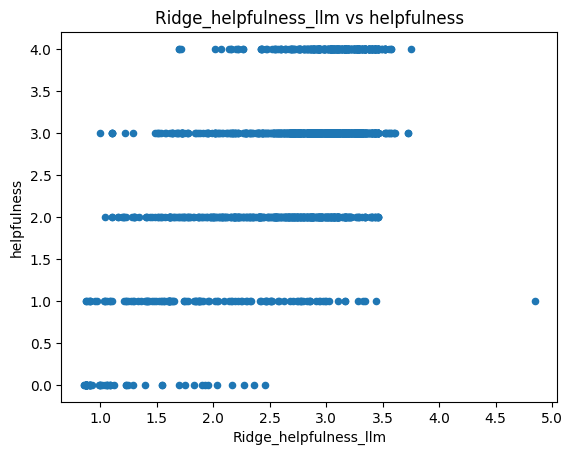

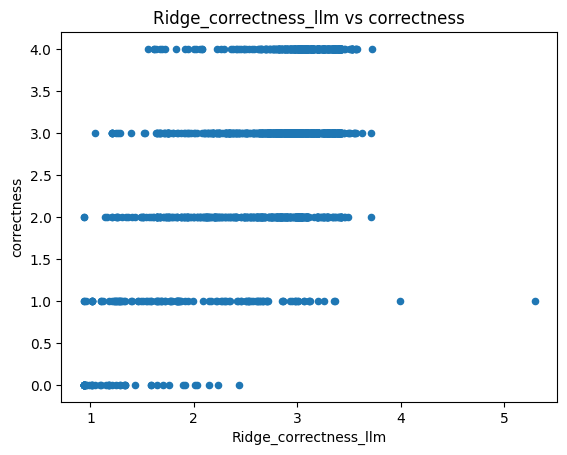

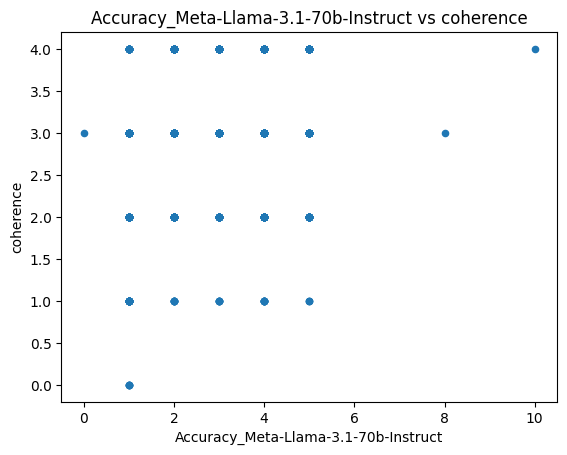

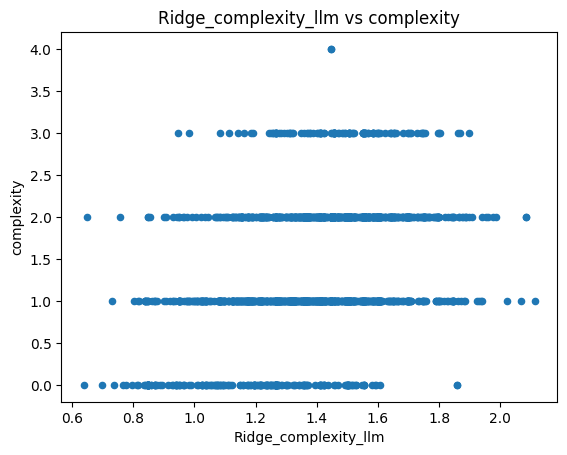

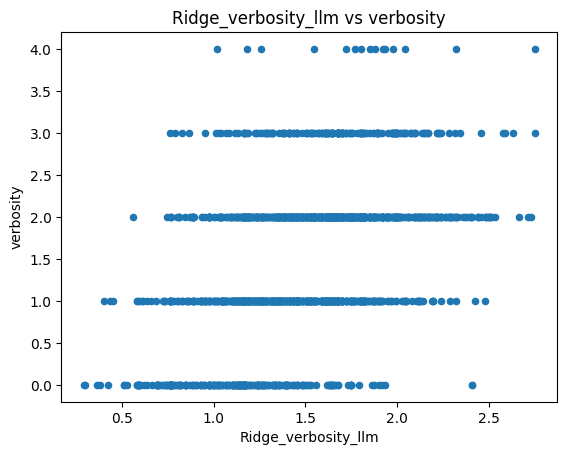

In [17]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
